In [1]:
# Main imports
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.stats as spstat
import scipy.signal as spsig

from typing import Union, Callable, Tuple
from enum import Enum
from matplotlib.figure import Figure

---
## Problem Introduction

We consider the problem of calculating fair value for Asian and lookback options contracts which exhibit path dependence. In the case of Asian options, every variant has a payoff function that factors in an average stock price over some time period, typically from contract inception to expiry. For lookback options, instead either a maximum or minimum value taken by the stock over the period is factored in. Each option type can also come in a floating or fixed variant, with the latter having a static strike price set at the contract's inception. Additionally, Asian options can utilize a continuous or discrete average, the latter having a discrete sampling rate set at the contract's inception.

We will use martingale pricing to value these options. Assume $S$ is a stock price following a risk-neutral log-normal random walk and let $V(S,T)$ by the payoff function for an option on the stock at expiry time $T$. From the no arbitrage principle, we therefore have the following fair option price at a time $0 \leq t \leq T$:

$$V(S,t) = e^{-r(T-t)} \mathbb{E}_t \left[ V(S,T) \right]$$

Where $\mathbb{E}_t$ is the expectation of a stochastic process conditioned on a filtration $\mathcal{F}_t$ at time $t$.

We will utilize the Euler-Maruyama scheme to simulate discretized paths from the stock price stochastic differential equation (SDE):

$$dS_t = \mu S_t dt + \sigma S_t dW_t$$

Where $\mu, \sigma$ are the annualised return and instantaneous annualised volatility respectively of the stock price, $t$ is time and $dW_t$ is an infinitesimal Wiener increment. Once a sufficient number of simulated paths are generated, we simply average over the set of paths as a Monte Carlo estimate of expectation.

---
## Class Construction

In order to encapsulate and reuse functionality, we will construct a number of classes for general functionality and build specific instances of relevant models on top.

--
### Diffusion Models

We start with classes responsible for generating observed paths for diffusion models of interest. First, we create a base diffusion model class that supports the following general SDE pattern:

$$dX_t = \mu(X,t) dt + \sigma(X,t) dW_t$$

where $X_t$ is the stochastic process in question. The Euler-Maruyama scheme to approximate this process is given by iterative equation:

$$\delta X_t = \mu(X_t,t) \delta t + \sigma(X_t,t) \delta W_t$$

where $\delta X_t, \delta t, \delta W_t$ represent small discrete steps in $X_t, t$ and $W_t$ respectively. We select an adequately small time step $\delta t << 1$ and recall that as $W_t$ is a Wiener process, a discrete increment $\delta W_t$ over time increment $\delta t$ is Normally distributed with variance $\delta t$.

Subsequent concrete classes will supply specific functions for $\mu$ and $\sigma$ and leverage the base class for computation.

#### Base Diffusion Class

In [2]:
# Base diffusion model
class DiffusionModel:

    def __init__(self,
                 drift : Union[np.ndarray, Callable], # Drift parameter - can be fixed value, time varying array or function
                 diffusion : Union[np.ndarray, Callable], # Diffusion parameter - can be fixed value, time varying array or function
                 x_0 : np.ndarray, # Starting value
                 t_0 : float, # Starting time
                 T : float, # End time
                 dt : float, # Time step for EM process
                 seed : int): # Random seed for reproducible results

        self.drift = drift
        self.diffusion = diffusion
        self.x_0 = x_0
        self.t_0 = t_0
        self.T = T
        self.dt = dt
        self.N = int(T / dt) # Calculate the number of time steps
        self._time_axis = np.linspace(t_0, T, self.N + 1) # Create time axis
        self._seed = seed
        self.dW = None # For storing discrete Wiener realizations in some cases

    @property
    def time_axis(self):
        return self._time_axis

    @property
    def drift(self):
        return self._drift

    @drift.setter
    def drift(self, drift):
        self._drift = drift
        self._drift_is_callable = callable(drift) # Detect if drift parameter is a function

    @property
    def diffusion(self):
        return self._diffusion

    @diffusion.setter
    def diffusion(self, diffusion):
        self._diffusion = diffusion
        self._diffusion_is_callable = callable(diffusion) # Detect if diffusion parameter is a function

    @property
    def seed(self):
        return self._seed

    @seed.setter
    def seed(self, seed):
        if self._seed != seed:
            self.dW = None # Reset stored discrete Wiener realizations if seed changed
            self._seed = seed

    # Get drift value
    def compute_drift(self, x, t):
        if self._drift_is_callable:
            return self.drift(x, t) # If drift is function, call it with value and time arguments

        return self.drift

    # Get diffusion value
    def compute_diffusion(self, x, t):
        if self._diffusion_is_callable:
            return self.diffusion(x, t) # If diffusion is function, call it with value and time arguments

        return self.diffusion

    # Generate, store and return Wiener increment realizations for Euler-Maruyama process
    def _compute_wiener_increments(self, n):
        # If no stored realizations (seed change removes) or shape changed, regenerate
        if self.dW is None or self.dW.shape != (n, self.N):
            self.dW = np.random.standard_normal(size=(n, self.N)) * np.sqrt(self.dt)

        # Else return stored realizations to save computation
        return self.dW

    # Pass the seed through to numpy

    # Generate Euler-Maruyama approximations for diffusion process
    def generate_em_paths(self, n : int) -> np.ndarray:

        # Prepare path
        x = np.zeros(shape=(n, self.N + 1))

        # Set initial value
        x[:,0] = self.x_0

        # Reset numpy seed to configured seed value
        np.random.seed(self.seed)

        # Get Wiener process realizations
        dW = self._compute_wiener_increments(n)

        # Iterate through time steps
        for i in range(self.N):

            # Calculate time to expiry
            tau = i * self.dt

            # Compute drift
            mu = self.compute_drift(x[:,i], tau)

            # Compute diffusion
            sigma = self.compute_diffusion(x[:,i], tau)

            # Compute diffusion step
            dx = mu * self.dt + sigma * dW[:,i]

            # Compute next value in process
            x[:,i+1] = x[:,i] + dx

        # Return path
        return x

    # Return diffusion parameters for this instance as a dictionary
    def get_params(self) -> dict:
        return {
            "drift" : self.drift,
            "diffusion" : self.diffusion,
            "x_0" : self.x_0,
            "t_0" : self.t_0,
            "T" : self.T,
            "dt" : self.dt,
            "seed" : self.seed}



#### Risk Neutral Stock Model (Geometric Brownian Motion)

As described above, a GBM for a stochastic process $S_t$ can be characterized by the SDE $dS_t = \mu_S S_t dt + \sigma_S S_t dW_t$ where $\mu_S, \sigma_S$ are the drift and volatility of the process respectively. In the generalised diffusion SDE framework, this translates to parameters $\mu(S_t, t) = \mu_S S_t$ and $\sigma(S_t, t) = \sigma_S S_t$, which we pass through to the base diffusion class below.

In [3]:
# Risk neutral stock model following a geometric Brownian motion, built on top of base diffusion model
class RNStockModel(DiffusionModel):

    def __init__(self,
                 r : np.ndarray, # Interest rate - can be fixed value or time varying array
                 sigma : np.ndarray, # Volatility - can be fixed value or time varying array
                 S_0 : np.ndarray = np.array(100), # Starting stock value
                 t_0 : float = 0, # Starting time
                 T : float = 1, # End time
                 dt : float = 0.01, # Time step for EM process
                 seed : int = 0): # Random seed for reproducible results

        # Wrap rate parameter in numpy array if scalar (idempotent if already array)
        self.r = np.array(r)

        # Wrap sigma parameter in numpy array if scalar (idempotent if already array)
        self.sigma = np.array(sigma)

        # Store starting stock value
        self.S_0 = S_0

        # Set drift function for risk neutral log-normal process
        drift = lambda x, t: r * x

        # Set diffusion function for risk neutral log-normal process
        diffusion = lambda x, t: sigma * x

        # Pass to base class
        super().__init__(
            drift = drift,
            diffusion = diffusion,
            x_0 = S_0,
            t_0 = t_0,
            T = T,
            dt = dt,
            seed = seed)

    # Return stock model parameters for this instance as a dictionary
    def get_params(self):
        params = super().get_params()
        params.pop("x_0")
        params.pop("drift")
        params.pop("diffusion")
        params["S_0"] = self.S_0
        params["r"] = self.r
        params["sigma"] = self.sigma
        return params

### Option Pricing Classes

In a similar fashion as with our chosen diffusion models, we build a hierarchy of option valuation classes with base classes encapsulating the most generic features of option valuation and later concrete classes implementing specific attributes of the option contract in question.

#### Enum Classes

In [4]:
# Standard option parameters as enum
class OptionParameter(Enum):
    STOCK_PRICE = 1
    STRIKE_PRICE = 2
    VOLATILITY = 3
    INTEREST_RATE = 4

    # Return the enum name
    def get_name(self):
        return self.name.replace("_", " ").capitalize()

    # Return enum symbol
    def get_symbol(self):
        return {
            self.STOCK_PRICE : "S_0",
            self.STRIKE_PRICE : "E",
            self.VOLATILITY : "sigma",
            self.INTEREST_RATE : "r"
        }[self]

# Asian option averaging methods
class AsianOptionAverage(Enum):
    ARITHMETIC = 1
    GEOMETRIC = 2

#### Base Option Pricing Class

In [5]:
# Base stock option class for computing option price time series
class StockOption:

    def __init__(self,
                 stock_model : RNStockModel, # Stock model object
                 payoff_func : Callable, # Option payoff function
                 strike_price : float = None): # Option strike price

        self.stock_model = stock_model
        self.payoff_func = payoff_func
        self.strike_price = strike_price
        self.S = None

        # Prepare to internally store discrete interest rate integral for discounting
        self._r_integral = None

        # Store vectorized max function to be leveraged by payoff functions
        self.vec_max = np.vectorize(max, otypes=[float])

    # Compute and return interest rate integral
    def _get_r_integral(self,
                        r : np.ndarray, # Interest rate parameter
                        i : int = None): # Euler-Maruyama interation step

        # If the step is undefined or zero, compute interest rate integral
        if i is None or i == 0:

            # Get stored stock model
            S_model = self.stock_model

            # Static r, linear process - simply multiply r parameter by time axis
            if r.ndim == 0:
                self._r_integral = r * S_model.time_axis
            # Deterministic dynamic r - cumulative sum multiplied by time step
            elif r.ndim == 1:
                self._r_integral = r.cumsum() * S_model.dt

            # Stochastic r - cumulative sum over iteration steps multiplied by time step
            else:
                self._r_integral = r.cumsum(axis=1) * S_model.dt

        # Return entire integral process if i undefined, else value at specific point
        return self._r_integral if i is None else self._r_integral[i]

    # Compute option price time series
    def compute_price_time_series(self,
                                  n : int): # Number of Euler-Maruyama paths to simulate

        # Get internal stock model
        S_model = self.stock_model

        # Get interest rate parameter
        r = S_model.r

        # Compute Euler-Maruyama paths
        self.S = S_model.generate_em_paths(n)

        # Put through to internal compute method
        return self._compute_option_prices(r, self.S)

    # Compute option prices from rate parameter and stock paths
    def _compute_option_prices(self,
                               r : np.ndarray, # Interest rate
                               S : np.ndarray): # Stock paths

        # Get internal stock model
        S_model = self.stock_model

        # Get number of steps
        N = S_model.N

        # Initiate option values
        V = np.zeros(shape=N + 1)

        # Iterate through steps
        for i in range(N + 1):

            # Compute payoff function value
            V_i = self.payoff_func(S, i)

            # Get interest rate integral value at iteration step
            r_integral = self._get_r_integral(r, i)

            # Compute discount
            discount = np.exp(-r_integral)

            # Discount payoff function and compute average
            V[i] = (V_i * discount).mean()

        # Return option value time series
        return V

    # Compute option value surface by time and another variable
    def compute_price_time_parameter_surface(self,
                                             n : int, # Number of Euler-Maruyama paths to simulate
                                             option_param : OptionParameter, # Option parameter to vary
                                             min_value : float, # Min value for parameter span
                                             max_value : float): # Max value for parameter span

        # Get internal stock model
        S_model = self.stock_model

        # Initiate parameter range with 21 ticks
        parameter_space = np.linspace(min_value, max_value, 21)

        # Initiate option value surface
        V_surface = np.zeros(shape=(21, S_model.N + 1))

        # Get stock model parameters
        params = S_model.get_params()

        # Iterate over values in the parameter range
        for i, param_value in enumerate(parameter_space):

            # If the parameter is strike price and the option has a strike
            if option_param == OptionParameter.STRIKE_PRICE and self.strike_price is not None:

                # Generate Euler-Maruyama paths a single time
                if i == 0:
                    self.S = S_model.generate_em_paths(n)

                # Store stock model's original strike price
                orig_strike = self.strike_price

                # Set to current parameter value
                self.strike_price = param_value

                # Compute and store option value
                V_surface[i] = self._compute_option_prices(S_model.r, self.S)

                # Reset stock model's strike price to original
                self.strike_price = orig_strike

            else: # All other parameters

                # Get the option parameter symbol
                option_param_symbol = option_param.get_symbol()

                # Get option parameter value from stock model dictionary
                params[option_param_symbol] = param_value

                # Instantiate new stock model object with modified parameter
                S_model_modified = RNStockModel(**params)

                # Generate Euler-Maruyama paths for new parameter
                S_modified = S_model_modified.generate_em_paths(n)

                # Compute and store option value
                V_surface[i] = self._compute_option_prices(S_model_modified.r, S_modified)

        # Return time to expiry axis, parameter axis and option value surface
        return S_model.time_axis, parameter_space, V_surface

    # Generate full panel of option values by time and all option parameters
    def plot_price_time_parameter_panel(self,
                                        n : int, # Number of Euler-Maruyama paths to simulate
                                        param_ranges : dict[str, Tuple[float]]): # Dictionary of ranges for the parameters
        # Store internal stock models
        S_model = self.stock_model

        # Get stock model parameters
        params = S_model.get_params()

        # Collect option parameters
        option_params = [e for e in OptionParameter]

        # If strike price not present, remove from option parameters
        if self.strike_price is None:
            option_params.remove(OptionParameter.STRIKE_PRICE)
        else: # Store strike price for later
            params["E"] = self.strike_price

        # If no param ranges given, initiate empty dictionary
        if param_ranges is None:
            param_ranges = dict()

        # Get option count for figure rows
        fig_rows = len(option_params)

        # Compute figure height
        fig_height = 3.5 * fig_rows

        # Get figure
        fig = plt.figure(figsize=(12, fig_height))

        # Build required sub figures - cross-section plots and 3d surface
        param_sub_figs = fig.subfigures(fig_rows, 2)

        # Adjust 3d surface position
        param_sub_figs[0][1].subplots_adjust(left=-0.35)

        # Iterate over option parameters
        for i, option_param in enumerate(option_params):

            # Get the option parameter symbol
            param_symbol = option_param.get_symbol()

            # Get the option parameter range
            param_range = param_ranges.get(param_symbol)

            # If a single value given, centralize on it
            if type(param_range) is float:
                param_dist = abs(param_range - params.get(param_symbol))
                param_range = (max(param_range - param_dist, 0), param_range + param_dist)

            # Else take parameter range
            elif type(param_range) is tuple:
                param_range = param_range[:2]

            # Otherwise, blank from 0 to double the current parameter value
            else:
                param_range = (0, params.get(param_symbol) * 2)

            # Compute the option value surface for the given parameter
            time_axis, stock_axis, price_surface = self.compute_price_time_parameter_surface(n,
                                                                                             option_param,
                                                                                             param_range[0],
                                                                                             param_range[1])

            # Plot the parameter surface using the sub figure
            self.plot_price_time_parameter_surface(option_param.get_name(),
                                                   time_axis,
                                                   stock_axis,
                                                   price_surface,
                                                   param_sub_figs[i])
        # Return figure
        return fig

    @staticmethod
    def plot_price_time_parameter_surface(parameter_name : str, # Name of the parameter to display
                                          time_axis : np.ndarray, # Time axis array
                                          space_axis : np.ndarray, # Parameter space array
                                          surface : np.ndarray, # Option value surface
                                          subfigs : Figure = None): # Subfigures if adding to existing plot

        # Get time to expiry and parameter space coordinate mesh
        time_coords, space_coords = np.meshgrid(time_axis, space_axis)

        # Set time to expiry cross-sectional mappable
        time_cmap = mpl.colormaps["autumn"]
        time_norm = mpl.colors.Normalize(vmin = time_axis.min(), vmax=time_axis.max())
        time_mappable = mpl.cm.ScalarMappable(norm=time_norm, cmap=time_cmap)

        # Set parameter cross-sectional mappable
        space_cmap = mpl.colormaps["winter"]
        space_norm = mpl.colors.Normalize(vmin = space_axis.min(), vmax=space_axis.max())
        space_mappable = mpl.cm.ScalarMappable(norm=space_norm, cmap=space_cmap)

        # Set number of axis ticks
        ticks = 11

        # Prettify parameter name for axis title
        parameter_label = parameter_name.capitalize()

        # If no subfigure provided, create new figure
        if subfigs is None:
            fig = plt.figure(figsize=(20,5))
            subfigs = fig.subfigures(1, 2, width_ratios=[2,1])
            subfigs[1].subplots_adjust(left=-0.35)

        # Build grid spec with 2 columns
        grid = plt.GridSpec(1, 2, hspace=0, wspace=0.2)

        # Option parameter cross-section
        ax1 = subfigs[0].add_subplot(grid[0,0], ylabel="Option Price", xlabel=parameter_label)

        # Time to expiry cross-section
        ax2 = subfigs[0].add_subplot(grid[0,1], xlabel="Time")

        # 3d surface plot
        ax3 = subfigs[1].add_subplot(1, 1, 1, projection="3d", xlabel=parameter_label, ylabel="Time", zlabel="Option Price")

        # Plot parameter varying option values
        for j, c_j in enumerate(surface.T):
            t = time_axis[j]
            ax1.plot(
                space_axis,
                c_j,
                c = time_mappable.to_rgba(t))

        # Plot time varying option values
        for i, c_i in enumerate(surface):
            x = space_axis[i]
            ax2.plot(
                time_axis,
                c_i,
                c = space_mappable.to_rgba(x))

        # Get y-axis ranges for the two cross-sectional plots
        y_ranges = list(zip(ax1.get_ylim(), ax2.get_ylim()))

        # Compute the min and max of y ranges across both plots
        y_min, y_max = max(y_ranges[0]), max(y_ranges[1])

        # Set both plots to same y limits
        ax1.set_ylim(y_min, y_max)
        ax2.set_ylim(y_min, y_max)

        # Remove second plot ticks
        ax2.yaxis.set_ticklabels([])

        # Add colour bar to indicate time on parameter cross-sectional plot
        subfigs[0].colorbar(mappable = time_mappable,
                     ticks = np.linspace(time_axis.min(), time_axis.max(), ticks),
                     ax = ax1)

        # Add colour bar to indicate parameter value on time cross-sectional plot
        subfigs[0].colorbar(mappable = space_mappable,
                     ticks = np.linspace(space_axis.min(), space_axis.max(), ticks),
                     ax = ax2)

        # Plot the option value surface
        ax3.plot_surface(space_coords, time_coords, surface)

        # Rotate the x-axis labels
        ax3.tick_params(axis="x", labelrotation=90)

        # Pad the labels
        ax3.xaxis.labelpad = 15
        ax3.yaxis.labelpad = 10
        ax3.zaxis.labelpad = 5

        # Set the z-axis to the left (display issues)
        ax3.zaxis.set_ticks_position('lower')
        ax3.zaxis.set_label_position('lower')

#### Vanilla Call Option Class

In [6]:
# Vanilla call option class
class VanillaCallOption(StockOption):

    def __init__(self,
                 stock_model : RNStockModel, # Stock model object
                 strike_price : float): # Option strike price

        # Payoff function for vanilla call option
        def payoff(S, i):
            return self.vec_max(S[:,i] - self.strike_price, 0)

        # Pass parameters through to base option class
        super().__init__(
            stock_model = stock_model,
            payoff_func=payoff,
            strike_price=strike_price)

    # Compute theoretical option values for vanilla call based on Black-Scholes formula
    def compute_theoretical_price_time_series(self):

        # Get stored stock model object
        S_model = self.stock_model

        # Compute log ratio between stock price and strike price - log(S/E)
        log_ratio = np.log(S_model.S_0) - np.log(self.strike_price)

        # Compute modified for time in d_1 numerator (r - sigma^2 / 2)
        time_modifier = S_model.r + S_model.sigma ** 2 / 2

        # Initiate option values array
        V = np.zeros(shape=S_model.N+1)

        # Set option value to final payoff value when at expiry
        V[0] = max(S_model.S_0 - self.strike_price, 0)

        # Iterate through time to expiry steps
        for i in range(1, S_model.N + 1):

            # Compute time to expiry
            tau = i * S_model.dt - S_model.t_0

            # Pre-compute tau square root
            tau_sqrt = np.sqrt(tau)

            # Compute d_1 parameter
            d_1 = (log_ratio + time_modifier * tau) / (S_model.sigma * tau_sqrt)

            # Compute d_2 parameter
            d_2 = d_1 - S_model.sigma * tau_sqrt

            # Compute option price from vanilla call formula
            V[i] = S_model.S_0 * spstat.norm.cdf(d_1) - self.strike_price * np.exp(-S_model.r * tau) * spstat.norm.cdf(d_2)

        # Return option values array
        return V

#### Base Asian Option Class

In [7]:
# Base Asian option class for general Asian option functionality
class AsianOption(StockOption):

    def __init__(self,
                 stock_model : RNStockModel, # Stock model object
                 payoff_func : Callable, # Payoff function
                 strike_price : float = None, # Strike price (for fixed Asian options)
                 averaging_method : AsianOptionAverage = AsianOptionAverage.ARITHMETIC): # Averaging method of enum type

        # Store the averaging method
        self.averaging_method = averaging_method

        # Store internal running average array
        self._S_running_avg = None

        # Pass through to base option class
        super().__init__(
            stock_model = stock_model,
            payoff_func = payoff_func,
            strike_price = strike_price)

    # Method to compute the stock average leveraged by specific Asian option classes
    def compute_average(self,
                        S : np.ndarray, # Stock paths
                        i : int): # Iteration step

        # If first iteration step, compute the running average
        if i == 0:

            # Get stock path length
            N = S.shape[1]

            # Divisor for averaging
            divisor = np.arange(1, N+1)

            if self.averaging_method == AsianOptionAverage.ARITHMETIC:

                # If arithmetic average, calculate cumulative average
                self._S_running_avg = S.cumsum(axis=1) / divisor
            else:

                # If geometric average, compute log cumulative average and exponentiate
                self._S_running_avg = np.exp(np.log(S, out=np.zeros_like(S), where=(S != 0)).cumsum(axis=1) / divisor)

        # Get running average at iteration step
        S_avg = self._S_running_avg[:,i]
        return S_avg

#### Floating Asian Call Option Class

In [8]:
# Floating Asian call option class
class FloatingAsianCallOption(AsianOption):

    def __init__(self,
                 stock_model : RNStockModel, # Stock model object
                 averaging_method : AsianOptionAverage = AsianOptionAverage.ARITHMETIC): # Averaging method of enum type

        # Specific payoff function for floating Asian call
        def payoff(S, i):
            S_avg = self.compute_average(S, i)
            return self.vec_max(S[:,i] - S_avg, 0)

        # Pass through to base class
        super().__init__(
            stock_model = stock_model,
            payoff_func = payoff,
            averaging_method = averaging_method)

#### Floating Asian Put Option Class

In [9]:
# Floating Asian put option class
class FloatingAsianPutOption(AsianOption):

    def __init__(self,
                 stock_model : RNStockModel, # Stock model object
                 averaging_method : AsianOptionAverage = AsianOptionAverage.ARITHMETIC): # Averaging method of enum type

        # Specific payoff function for floating Asian put
        def payoff(S, i):
            S_avg = self.compute_average(S, i)
            return self.vec_max(S_avg - S[:,i], 0)

        # Pass through to base class
        super().__init__(
            stock_model = stock_model,
            payoff_func = payoff,
            averaging_method = averaging_method)

#### Fixed Asian Call Option Class

In [10]:
# Fixed Asian call option class
class FixedAsianCallOption(AsianOption):

    def __init__(self,
                 stock_model : RNStockModel, # Stock model object
                 strike_price : float, # Strike price
                 averaging_method : AsianOptionAverage = AsianOptionAverage.ARITHMETIC): # Averaging method of enum type

        # Specific payoff function for fixed Asian call
        def payoff(S, i):
            S_avg = self.compute_average(S, i)
            return self.vec_max(S_avg - self.strike_price, 0)

        # Pass through to base class
        super().__init__(
            stock_model = stock_model,
            payoff_func = payoff,
            strike_price = strike_price,
            averaging_method = averaging_method)

#### Fixed Asian Put Option Class

In [11]:

# Fixed Asian put option class
class FixedAsianPutOption(AsianOption):

    def __init__(self,
                 stock_model : RNStockModel, # Stock model object
                 strike_price : float, # Strike price
                 averaging_method : AsianOptionAverage = AsianOptionAverage.ARITHMETIC): # Averaging method of enum type

        # Specific payoff function for fixed Asian put
        def payoff(S, i):
            S_avg = self.compute_average(S, i)
            return self.vec_max(self.strike_price - S_avg, 0)

        # Pass through to base class
        super().__init__(
            stock_model = stock_model,
            payoff_func = payoff,
            strike_price = strike_price,
            averaging_method = averaging_method)

#### Base Lookback Option Class

Given a Brownian motion, two adjacent discretely sampled points will almost surely bookend a local extremum - that is for sampled points $B_{t_1}, B_{t^*}, B_{t_2} : t_1 < t^* < t_2$ we have $B_{t^*} > \max(B_{t_1}, B_{t_2})$ or $B_{t^*} > \min(B_{t_1}, B_{t_2})$ almost surely. As lookback options consider past extrema of the stock value process, our sampling will miss these points and induce a bias in the pricing. A solution to this issue involves sampling the maximum value via a Brownian bridge between each of the discretely sampled points. 

Let $B_t$ be a generalised Brownian motion. With slight modifications to include a non-unity diffusion term $\sigma$ and shift the starting value $B_t$, the distribution function required is provided by as below.

Let $M_t = \max_{t \leq s \leq T} B_s$, then

$$\begin{align*}
    \mathbb{P}(M_T \geq a | B_T = b, B_t = 0) &= \mathbb{P}(M_T \geq a + c | B_T = b + c, B_t = c) \\
    &= \exp \left\{ - \frac{2 (a - c)(a - b)}{\sigma^2(T - t)} \right\}, a \geq \max(b, c)
\end{align*}$$

Thus,
$$
    F_{M_T|B_T, B_t}(a | b, c) = \mathbb{P}(M_T \leq a | B_T = b, B_t = 0) = 1 - \exp \left\{ - \frac{2 (a - c)(a - b)}{\sigma^2(T - t)} \right\} , a \geq \max(b, c)
$$

The effect of shifting the starting value $B_t$ is simply a translation of the distribution along the $x$-axis.

Let $U \sim \mathcal{U}(0,1)$ be a continuous uniform random variate with support $(0,1)$, then by inversion Monte Carlo,

$$\begin{align*}
    U &= F_{M_T|B_T, B_t}(a | b, c) \\
    \log(1 - U) &= - \frac{2(a - c)(a - b)}{\sigma^2(T - t)} \\
    \sigma^2(T - t)\log(1 - U) &= - 2(a - c)(a - b) \\
    2a^2 - 2b(a + c) + \sigma^2 (T - t) \log(1 - U) + 2bc &= 0
\end{align*}$$

We arrive at a quadratic equation for $a$ in terms of $U$, which has solutions:

$$
\begin{align*}
    a &= \frac{(b + c) \pm \sqrt{(b + c)^2 - 2 \sigma^2 (T-t) \log(1 - U) - 4bc}}{2} \\
      &= \frac{(b + c) \pm \sqrt{(b - c)^2 - 2 \sigma^2 (T-t) \log(1 - U)}}{2}
\end{align*}
$$

The first solution is the only viable option (see below for justification):

$$a = \frac{(b + c) + \sqrt{(b - c)^2 - 2 \sigma^2 (T-t) \log(1 - U)}}{2}$$

Which we use as the basis for our inversion Monte Carlo approach.

----------

We demonstrate that the second solution of the above quadratic equation violates the constraints $a \geq \max(b, c)$ and need not be considered.

Recall the second solution

$$a = \frac{(b + c) - \sqrt{(b - c)^2 - 2 \sigma^2 (T-t) \log(1 - U)}}{2}$$

As $\log(1 - U) \leq 0$, then

$$\sqrt{(b - c)^2 - 2 \sigma^2 (T-t) \log(1 - U)} \geq \sqrt{(b - c)^2} = |b - c|$$

Therefore, 

$$\begin{align*}
a &= \frac{(b + c) - \sqrt{(b - c)^2 - 2 \sigma^2 (T-t) \log(1 - U)}}{2}
  &\leq \frac{b + c - |b - c|}{2}
\end{align*}$$

If $b \geq c$ then 

$$a \leq \frac{b + c - |b - c|}{2} = \frac{b + c - (b - c)}{2} = c$$

And if $c \geq b$ then 

$$a \leq \frac{b + c - |b - c|}{2} = \frac{b + c - (c - b)}{2} = b$$

In either case, the constraint is violated.

In [12]:
# Base lookback option class for general functionality.
class LookbackOption(StockOption):

    def __init__(self,
                 stock_model : RNStockModel, # Stock model object.
                 payoff_func : Callable, # Payoff function.
                 use_brownian_bridge : bool = True, # Use Brownian bridges between Euler-Maruyama time steps.
                 strike_price : float = None): # Strike price, for fixed options.

        # Internally store running extrema values.
        self._S_running_extrema = {
            "maxima": None,
            "minima": None
        }

        self.use_brownian_bridge = use_brownian_bridge

        # Pass to base class.
        super().__init__(
            stock_model = stock_model,
            payoff_func = payoff_func,
            strike_price = strike_price)
        
    # Compute the running extremum.
    def get_running_extremum(self,
                             S : np.ndarray, # Euler-Maruyama stock paths.
                             i : int, # Iteration step.
                             maximum : bool = True): # Get the maximum (otherwise, minimum).
        
        extrema_type = "maxima" if maximum else "minima"
        existing_extrema = self._S_running_extrema.get(extrema_type)
        
        # If iteration already started and existing extrema exists, return.
        if i > 0 and existing_extrema is not None:
            return existing_extrema[:,i]

        # Else, compute extrema.

        # If using Brownian Bridge.
        if self.use_brownian_bridge:

            # Get Wiener process from log-normal stock process.
            B = np.log(S)

            # Invert if minimum.
            if not maximum:
                B = -B

            # Compute maxima using Brownian bridges.
            B_max = self._generate_bridge_maxima(B)

            # Get the running maximum.
            B_max = np.maximum.accumulate(B_max, axis=1)
            
            # Invert again if minimum.
            if not maximum:
                B_max = -B_max

            # Exponentiate back to log-normal for stock extrema.
            S_ext = np.exp(B_max)

            # Store running maximum.
            self._S_running_extrema[extrema_type] = S_ext
        else:            
            
            # Invert if minimum.
            S_max = S if maximum else -S
            
            # Store running maximum from discrete prices.
            S_max = np.maximum.accumulate(S_max, axis=1)

            # Invert again if minimum.
            self._S_running_extrema[extrema_type] = S_max if maximum else -S_max

        # Return extrema.
        return self._S_running_extrema[extrema_type][:,i]

    # Compute Brownian bridge maxima.
    def _generate_bridge_maxima(self,
                                B : np.ndarray): # Brownian motion paths.

        # Get paths shape.
        n, N = B.shape

        # Get internal stock model.
        S_model = self.stock_model

        # Get stock parameters.
        dt = S_model.dt
        seed = S_model.seed

        # Reset seed.
        if seed is not None:
            np.random.seed(seed)        
        
        # Generate uniform normal variates U.
        U = np.random.uniform(size=(n, N - 1))

        # Compute the squared adjacent Brownian differences (b - c)^2.
        B_diffs_sq = np.diff(B)**2

        # Compute adjacent Brownian sums (b + c).
        B_adds = spsig.convolve2d(B, np.ones((1, 2)), "valid")

        # Compute simulated Brownian Bridge maxima from inversion Monte Carlo (a = [(b + c) - sqrt{ (b - c)^2 - 2 * sigma * (T - t) * log(1 - U) }] / 2).
        B_max = (B_adds + np.sqrt(B_diffs_sq - 2 * S_model.sigma**2 * dt * np.log(1 - U))) / 2

        # Add first value.
        B_max = np.hstack((np.atleast_2d(B[:,0]).T, B_max))

        # Return Brownian bridge maxima.
        return B_max

#### Floating Lookback Call Option Class

In [13]:
# Floating lookback call option class
class FloatingLookbackCallOption(LookbackOption):

    def __init__(self,
                 stock_model : RNStockModel, # Euler-Maruyama stock paths
                 use_brownian_bridge : bool = True): # Use Brownian Bridges

        # Payoff function for floating lookback call option
        def payoff(S, i):
            S_min = self.get_running_minimum(S, i)
            return S[:,i] - S_min

        # Pass to base class
        super().__init__(
            stock_model = stock_model,
            payoff_func = payoff,
            use_brownian_bridge = use_brownian_bridge)

    # Compute theoretical price for floating lookback call using Black-Scholes formula
    def compute_theoretical_price(self,
                                  time_modifier : float, # Time modifier in d_1 parameter
                                  i : int): # Iterative step

        # Internal stock model
        S_model = self.stock_model

        # Time to expiry
        tau = i * S_model.dt - S_model.t_0

        # Pre-compute tau square root
        tau_sqrt = np.sqrt(tau)

        # Wiener process standard dev
        sd = S_model.sigma * tau_sqrt

        # Compute discounting
        discount = np.exp(-S_model.r * tau)

        # Compute d_1 parameter
        d_1 = time_modifier * tau / sd

        # Compute d_2 parameter
        d_2 = d_1 - sd

        # Compute d_3 parameter
        d_3 = d_1 - 2 * S_model.r * tau_sqrt / S_model.sigma

        # Return theoretical option price
        return (S_model.S_0 * spstat.norm.cdf(d_1)
            - S_model.S_0 * discount * spstat.norm.cdf(d_2)
            - (S_model.S_0 * S_model.sigma**2 / (2 * S_model.r)) * (spstat.norm.cdf(-d_1) - discount * spstat.norm.cdf(-d_3)))


    # Compute full time series of theoretical prices
    def compute_theoretical_price_time_series(self):

        # Internal stock model
        S_model = self.stock_model

        # Time modifier for d_1 parameter
        time_modifier = S_model.r + S_model.sigma ** 2 / 2

        # Initiate option value array
        V = np.zeros(shape=S_model.N+1)

        # Set initial option value to zero
        V[0] = 0

        # Iterate through time steps
        for i in range(1, S_model.N + 1):

            # Compute option value
            V[i] = self.compute_theoretical_price(time_modifier, i)

        # Return option value time series
        return V

#### Floating Lookback Put Option Class

In [14]:
# Floating lookback put option class
class FloatingLookbackPutOption(LookbackOption):

    def __init__(self,
                 stock_model : RNStockModel, # Euler-Maruyama stock paths
                 use_brownian_bridge : bool = True): # Use Brownian Bridges

        # Payoff function for floating lookback puts
        def payoff(S, i):
            S_max = self.get_running_maximum(S, i)
            return S_max - S[:,i]

        # Pass to base class
        super().__init__(
            stock_model = stock_model,
            payoff_func = payoff,
            use_brownian_bridge = use_brownian_bridge)

    # Compute theoretical price for floating lookback call using Black-Scholes formula
    def compute_theoretical_price(self,
                                  time_modifier : float, # Time modifier in d_1 parameter
                                  i : int):

        # Internal stock model
        S_model = self.stock_model

        # Time to expiry
        tau = i * S_model.dt - S_model.t_0

        # Pre-compute tau square root
        tau_sqrt = np.sqrt(tau)

        # Wiener process standard dev
        sd = S_model.sigma * tau_sqrt

        # Discounting factor
        discount = np.exp(-S_model.r * tau)

        # Compute d_1 parameter
        d_1 = time_modifier * tau / sd

        # Compute d_2 parameter
        d_2 = d_1 - sd

        # Compute d_2 parameter
        d_3 = d_1 - 2 * S_model.r * tau_sqrt / S_model.sigma

        # Return theoretical value
        return (- S_model.S_0 * spstat.norm.cdf(-d_1)
                + S_model.S_0 * discount * spstat.norm.cdf(-d_2)
                + (S_model.S_0 * S_model.sigma**2 / (2 * S_model.r)) * (spstat.norm.cdf(d_1) - discount * spstat.norm.cdf(d_3)))

    # Compute full time series of theoretical prices
    def compute_theoretical_price_time_series(self):

        # Get internal stock model
        S_model = self.stock_model

        # Calculate time modified for numerator in d_1
        time_modifier = S_model.r + S_model.sigma ** 2 / 2

        # Initiate option value array
        V = np.zeros(shape=S_model.N+1)

        # Set final option value to zero
        V[0] = 0

        # Iterate through time steps
        for i in range(1, S_model.N + 1):

            # Compute theoretical price
            V[i] = self.compute_theoretical_price(time_modifier, i)

        # Return option price time series
        return V

#### Fixed Lookback Call Option Class

In [15]:
# Fixed lookback call option class
class FixedLookbackCallOption(LookbackOption):

    def __init__(self,
                 stock_model : RNStockModel,
                 strike_price : float,
                 use_brownian_bridge : bool = True):

        def payoff(S, i):
            S_max = self.get_running_maximum(S, i)
            return self.vec_max(S_max - self.strike_price, 0)

        super().__init__(
            stock_model = stock_model,
            payoff_func = payoff,
            strike_price = strike_price,
            use_brownian_bridge = use_brownian_bridge)

    def compute_theoretical_price(self,
                                  log_drift : float,
                                  i : int):

        S_model = self.stock_model
        sigma = S_model.sigma
        S_0 = S_model.S_0
        r = S_model.r
        E = self.strike_price
        tau = i * S_model.dt - S_model.t_0
        tau_sqrt = np.sqrt(tau)
        sd = sigma * tau_sqrt
        discount = np.exp(-r * tau)
        K = max(S_0, E)
        log_ratio = np.log(S_0) - np.log(K)
        d_1 = (log_ratio + log_drift * tau) / sd
        d_2 = d_1 - sd
        d_3 = d_1 - 2 * r * tau_sqrt / sigma
        H = (S_0 * spstat.norm.cdf(d_1)
             - discount * K * spstat.norm.cdf(d_2)
             + (S_0 * sigma**2 / (2 * r)) * (spstat.norm.cdf(d_1) - (S_0 / K) ** (-2 * r / sigma ** 2) * discount * spstat.norm.cdf(d_3)))

        return discount * max(S_0 - E, 0) + H

    def compute_theoretical_price_time_series(self):
        S_model = self.stock_model
        log_drift = S_model.r + S_model.sigma ** 2 / 2
        V = np.zeros(shape=S_model.N+1)
        V[0] = max(S_model.S_0 - self.strike_price, 0)

        for i in range(1, S_model.N + 1):
            V[i] = self.compute_theoretical_price(log_drift, i)

        return V

#### Fixed Lookback Put Option Class

In [16]:
# Fixed lookback put option class
class FixedLookbackPutOption(LookbackOption):

    def __init__(self,
                 stock_model : RNStockModel,
                 strike_price : float,
                 use_brownian_bridge : bool = True):

        def payoff(S, i):
            S_min = self.get_running_minimum(S, i)
            return self.vec_max(self.strike_price - S_min, 0)

        super().__init__(
            stock_model = stock_model,
            payoff_func = payoff,
            strike_price = strike_price,
            use_brownian_bridge = use_brownian_bridge)

    def compute_theoretical_price(self,
                                  log_drift : float,
                                  i : int):

        S_model = self.stock_model
        r = S_model.r
        sigma = S_model.sigma
        S_0 = S_model.S_0
        tau = i * S_model.dt - S_model.t_0
        tau_sqrt = np.sqrt(tau)
        sd = sigma * tau_sqrt
        discount = np.exp(-r * tau)
        E = self.strike_price
        K = min(S_0, E)
        log_ratio = np.log(S_0) - np.log(K)
        d_1 = (log_ratio + log_drift * tau) / sd
        d_2 = d_1 - sd
        d_3 = d_1 - 2 * r * tau_sqrt / sigma
        H = (- S_0 * spstat.norm.cdf(-d_1)
             + K * discount * spstat.norm.cdf(-d_2)
             - (S_0 * sigma**2 / (2 * r)) * (spstat.norm.cdf(-d_1) - (S_0 / K) ** (-2 * r / sigma ** 2) * discount * spstat.norm.cdf(-d_3)))

        return discount * max(E - S_0, 0) + H

    def compute_theoretical_price_time_series(self):
        S_model = self.stock_model
        log_drift = S_model.r + S_model.sigma ** 2 / 2
        V = np.zeros(shape=S_model.N+1)
        V[0] = max(self.strike_price - S_model.S_0, 0)

        for i in range(1, S_model.N + 1):
            V[i] = self.compute_theoretical_price(log_drift, i)

        return V

## Pricing Exploration and Testing

In [17]:
class OptionPlotter:

    # Generate full panel of option values by time and all option parameters.
    @classmethod
    def plot_price_time_parameter_panel(cls,
                                        option: StockOption,
                                        n : int, # Number of Euler-Maruyama paths to simulate.
                                        param_ranges : dict[str, Tuple[float]]): # Dictionary of ranges for the parameters.
       
        # Store internal stock model.
        S_model = option.stock_model

        # Get stock model parameters.
        params = S_model.get_params()

        # Collect option parameters.
        option_params = [e for e in OptionParameter]

        # If strike price not present, remove from option parameters.
        if option.strike_price is None:
            option_params.remove(OptionParameter.STRIKE_PRICE)

        else: # Store strike price for later.
            params["E"] = option.strike_price

        # If no param ranges given, initiate empty dictionary.
        if param_ranges is None:
            param_ranges = dict()

        # Get option count for figure rows.
        fig_rows = len(option_params)

        # Compute figure height.
        fig_height = 3.5 * fig_rows

        # Get figure.
        fig = plt.figure(figsize=(12, fig_height))

        # Build required sub figures - cross-section plots and 3d surface.
        param_sub_figs = fig.subfigures(fig_rows, 2)

        # Adjust 3d surface position.
        param_sub_figs[0][1].subplots_adjust(left=-0.35)

        # Iterate over option parameters.
        for i, option_param in enumerate(option_params):

            # Get the option parameter symbol.
            param_symbol = option_param.get_symbol()

            # Get the option parameter range.
            param_range = param_ranges.get(param_symbol)

            # If a single value given, centralize on it.
            if type(param_range) is float:
                param_dist = abs(param_range - params.get(param_symbol))
                param_range = (max(param_range - param_dist, 0), param_range + param_dist)

            # Else take parameter range.
            elif type(param_range) is tuple:
                param_range = param_range[:2]

            # Otherwise, blank from 0 to double the current parameter value.
            else:
                param_range = (0, params.get(param_symbol) * 2)

            # Compute the option value surface for the given parameter.
            time_axis, stock_axis, price_surface = option.compute_price_time_parameter_surface(n,
                                                                                               option_param,
                                                                                               param_range[0],
                                                                                               param_range[1])

            # Plot the parameter surface using the sub figure.
            cls.plot_price_time_parameter_surface(option_param.get_name(),
                                                  time_axis,
                                                  stock_axis,
                                                  price_surface,
                                                  param_sub_figs[i])
        # Return figure
        return fig

    @staticmethod
    def plot_price_time_parameter_surface(parameter_name : str, # Name of the parameter to display.
                                          time_axis : np.ndarray, # Time axis array.
                                          space_axis : np.ndarray, # Parameter space array.
                                          surface : np.ndarray, # Option value surface.
                                          subfigs : Figure = None): # Subfigures if adding to existing plot.

        # Get time to expiry and parameter space coordinate mesh.
        time_coords, space_coords = np.meshgrid(time_axis, space_axis)

        # Set time to expiry cross-sectional mappable.
        time_cmap = mpl.colormaps["autumn"]
        time_norm = mpl.colors.Normalize(vmin = time_axis.min(), vmax=time_axis.max())
        time_mappable = mpl.cm.ScalarMappable(norm=time_norm, cmap=time_cmap)

        # Set parameter cross-sectional mappable.
        space_cmap = mpl.colormaps["winter"]
        space_norm = mpl.colors.Normalize(vmin = space_axis.min(), vmax=space_axis.max())
        space_mappable = mpl.cm.ScalarMappable(norm=space_norm, cmap=space_cmap)

        # Set number of axis ticks.
        ticks = 11

        # Prettify parameter name for axis title.
        parameter_label = parameter_name.capitalize()

        # If no subfigure provided, create new figure.
        if subfigs is None:
            fig = plt.figure(figsize=(20,5))
            subfigs = fig.subfigures(1, 2, width_ratios=[2,1])
            subfigs[1].subplots_adjust(left=-0.35)

        # Build grid spec with 2 columns.
        grid = plt.GridSpec(1, 2, hspace=0, wspace=0.2)

        # Option parameter cross-section.
        ax1 = subfigs[0].add_subplot(grid[0,0], ylabel="Option Price", xlabel=parameter_label)

        # Time to expiry cross-section.
        ax2 = subfigs[0].add_subplot(grid[0,1], xlabel="Expiration Time")

        # 3d surface plot.
        ax3 = subfigs[1].add_subplot(1, 1, 1, projection="3d", xlabel=parameter_label, ylabel="Expiration Time", zlabel="Option Price")

        # Plot parameter varying option values.
        for j, c_j in enumerate(surface.T):
            t = time_axis[j]
            ax1.plot(
                space_axis,
                c_j,
                c = time_mappable.to_rgba(t))

        # Plot time varying option values.
        for i, c_i in enumerate(surface):
            x = space_axis[i]
            ax2.plot(
                time_axis,
                c_i,
                c = space_mappable.to_rgba(x))

        # Get y-axis ranges for the two cross-sectional plots.
        y_ranges = list(zip(ax1.get_ylim(), ax2.get_ylim()))

        # Compute the min and max of y ranges across both plots.
        y_min, y_max = max(y_ranges[0]), max(y_ranges[1])

        # Set both plots to same y limits.
        ax1.set_ylim(y_min, y_max)
        ax2.set_ylim(y_min, y_max)

        # Remove second plot ticks
        ax2.yaxis.set_ticklabels([])

        # Add colour bar to indicate time on parameter cross-sectional plot.
        subfigs[0].colorbar(mappable = time_mappable,
                     ticks = np.linspace(time_axis.min(), time_axis.max(), ticks),
                     ax = ax1)

        # Add colour bar to indicate parameter value on time cross-sectional plot.
        subfigs[0].colorbar(mappable = space_mappable,
                     ticks = np.linspace(space_axis.min(), space_axis.max(), ticks),
                     ax = ax2)

        # Plot the option value surface.
        ax3.plot_surface(space_coords, time_coords, surface)

        # Rotate the x-axis labels.
        ax3.tick_params(axis="x", labelrotation=90)

        # Pad the labels.
        ax3.xaxis.labelpad = 15
        ax3.yaxis.labelpad = 10
        ax3.zaxis.labelpad = 5

        # Set the z-axis to the left (display issues).
        ax3.zaxis.set_ticks_position('lower')
        ax3.zaxis.set_label_position('lower')

In [23]:
# Base parameters for tests
base_stock_params = {
    "r" : 0.05,
    "sigma" : 0.2,
    "S_0" : 100,
    "T" : 1,
    "dt" : 0.01,
    "seed" : 0 }

# Base strike price for tests
base_strike_price = 100

# Number of Euler-Maruyama simulations to run for each test
N_sims = 10000

# Risk neutral stock model object with base parameters
S_model = RNStockModel(**base_stock_params)

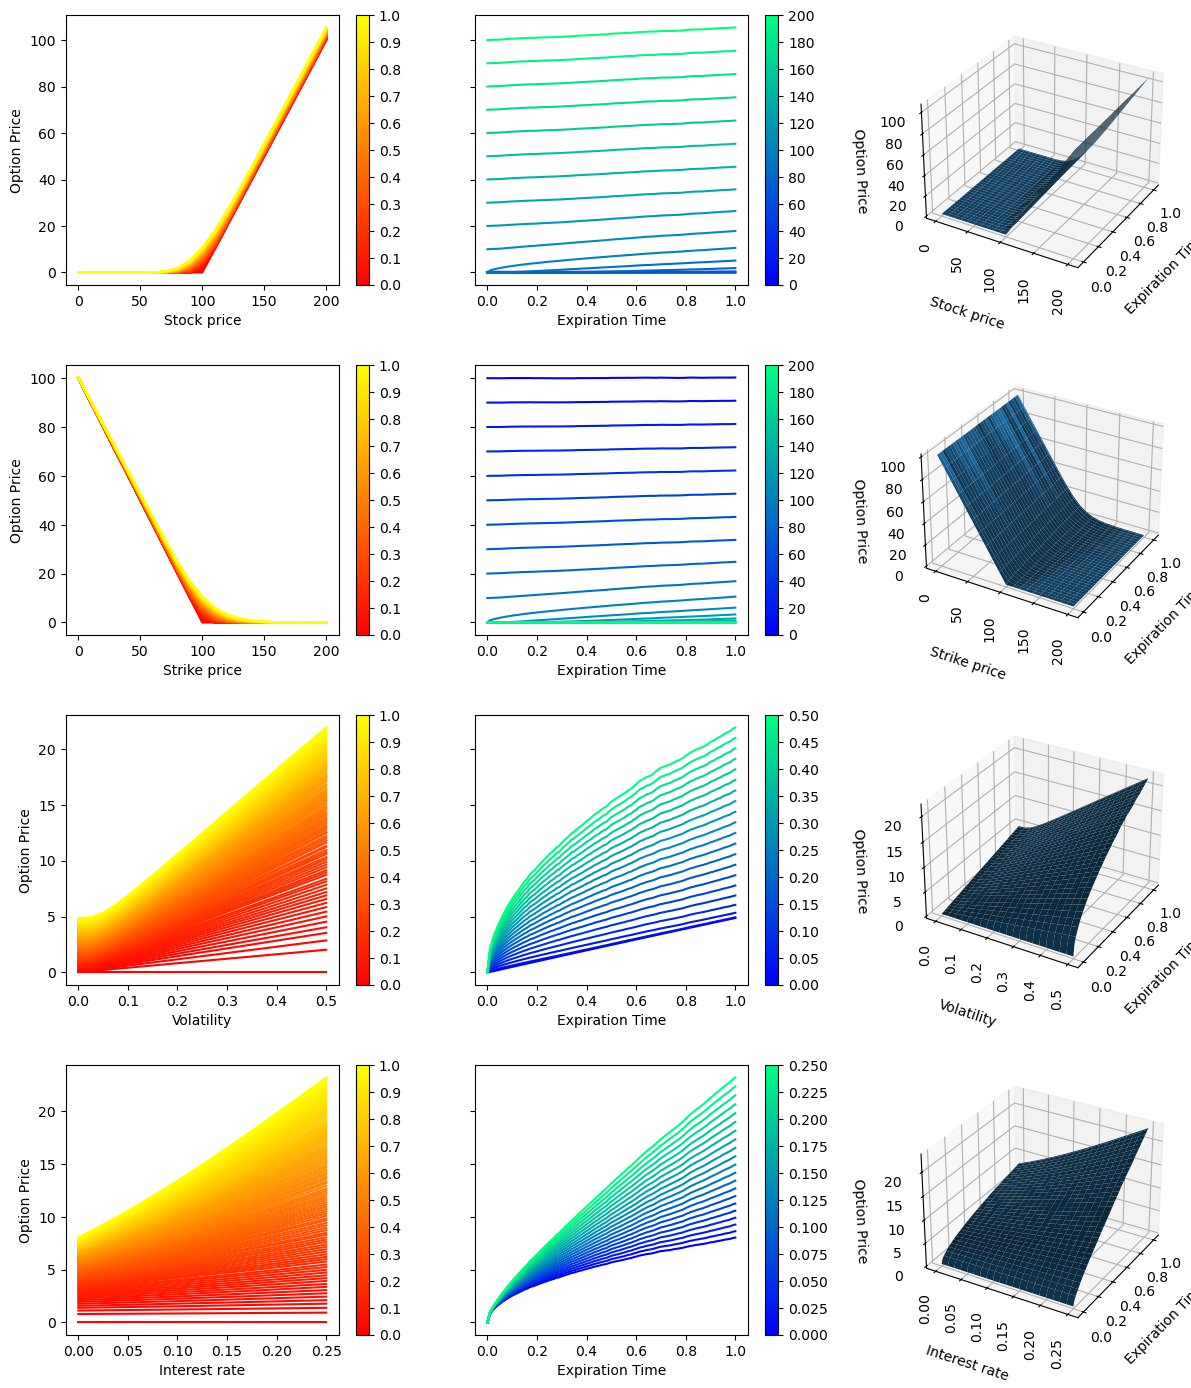

In [21]:
# Instantiate floating asian call option object with arithmetic averaging.
arith_floating_asian_call = VanillaCallOption(S_model, 100)

# Generate full pane plot for time and parameter cross-sections and surfaces.
fig = OptionPlotter.plot_price_time_parameter_panel(arith_floating_asian_call,
                                                    N_sims,
                                                    param_ranges = {"S_0" : (0,200),
                                                                    "sigma" : (0, 0.5),
                                                                    "r" : (0, 0.25)})

### Asian Options

#### Floating Asian Call

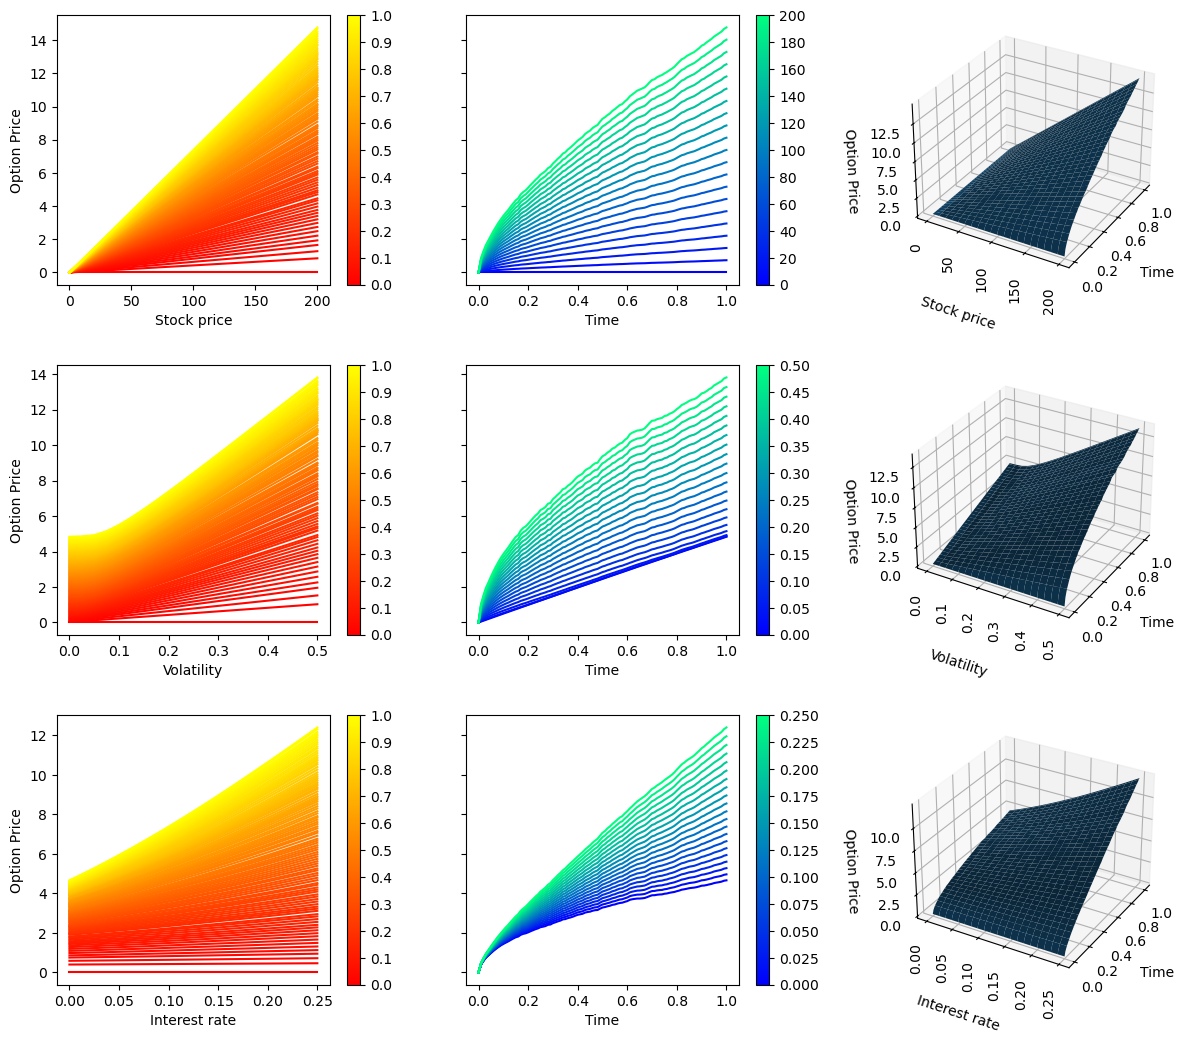

In [ ]:
# Instantiate floating asian call option object with arithmetic averaging.
arith_floating_asian_call = FloatingAsianCallOption(S_model, AsianOptionAverage.ARITHMETIC)

# Generate full pane plot for time and parameter cross-sections and surfaces.
fig = OptionPlotter.plot_price_time_parameter_panel(arith_floating_asian_call,
                                                    N_sims,
                                                    param_ranges = {"S_0" : (0,200),
                                                                    "sigma" : (0, 0.5),
                                                                    "r" : (0, 0.25)})

#### Floating Asian Put

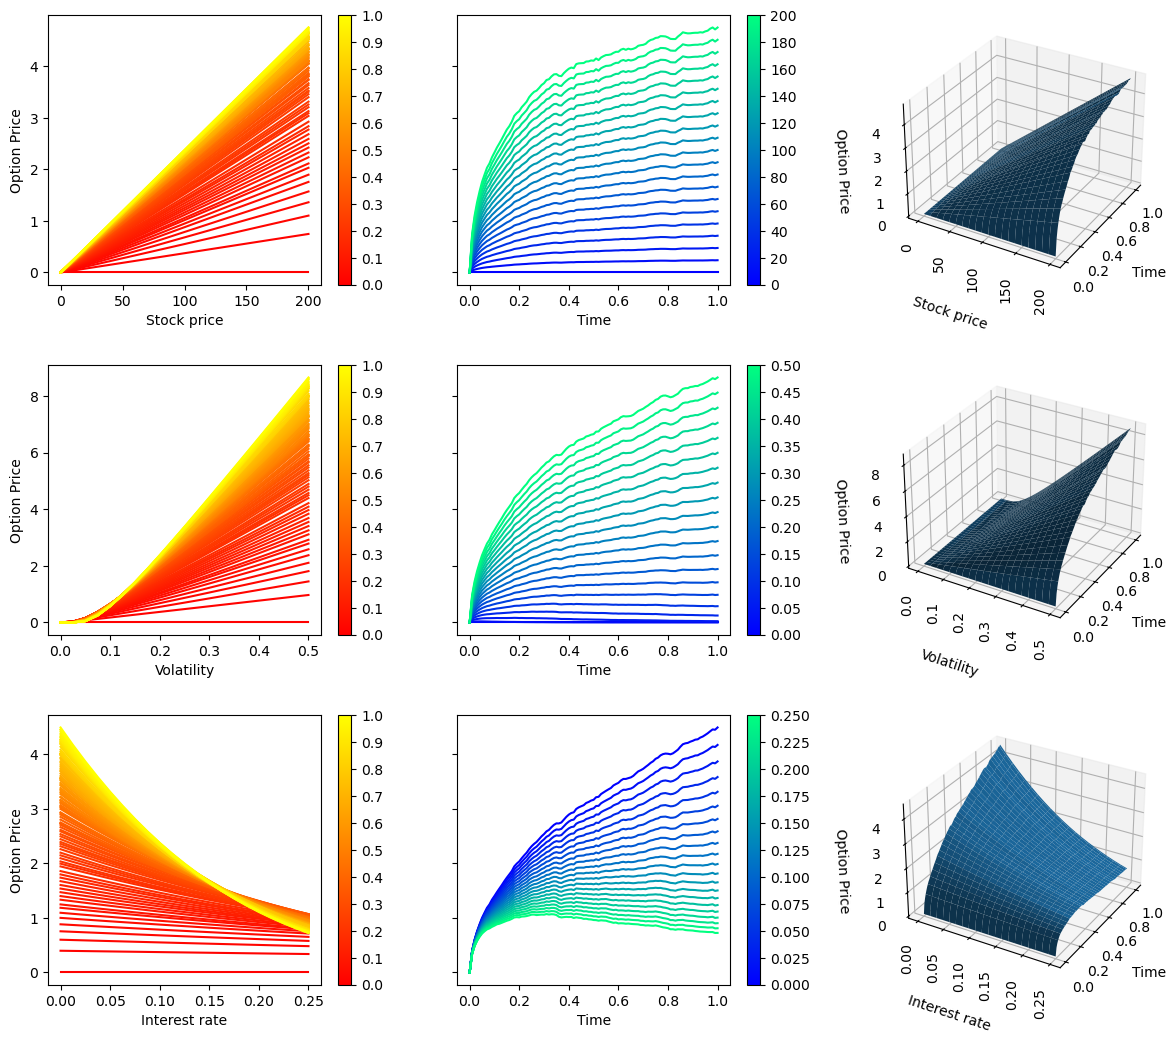

In [ ]:
# Instantiate floating asian put option object with arithmetic averaging.
arith_floating_asian_put = FloatingAsianPutOption(S_model, AsianOptionAverage.ARITHMETIC)

# Generate full pane plot for time and parameter cross-sections and surfaces.
fig = OptionPlotter.plot_price_time_parameter_panel(arith_floating_asian_put,
                                                    N_sims,
                                                    param_ranges = {"S_0" : (0,200),
                                                                    "sigma" : (0, 0.5),
                                                                    "r" : (0, 0.25)})

#### Fixed Asian Call

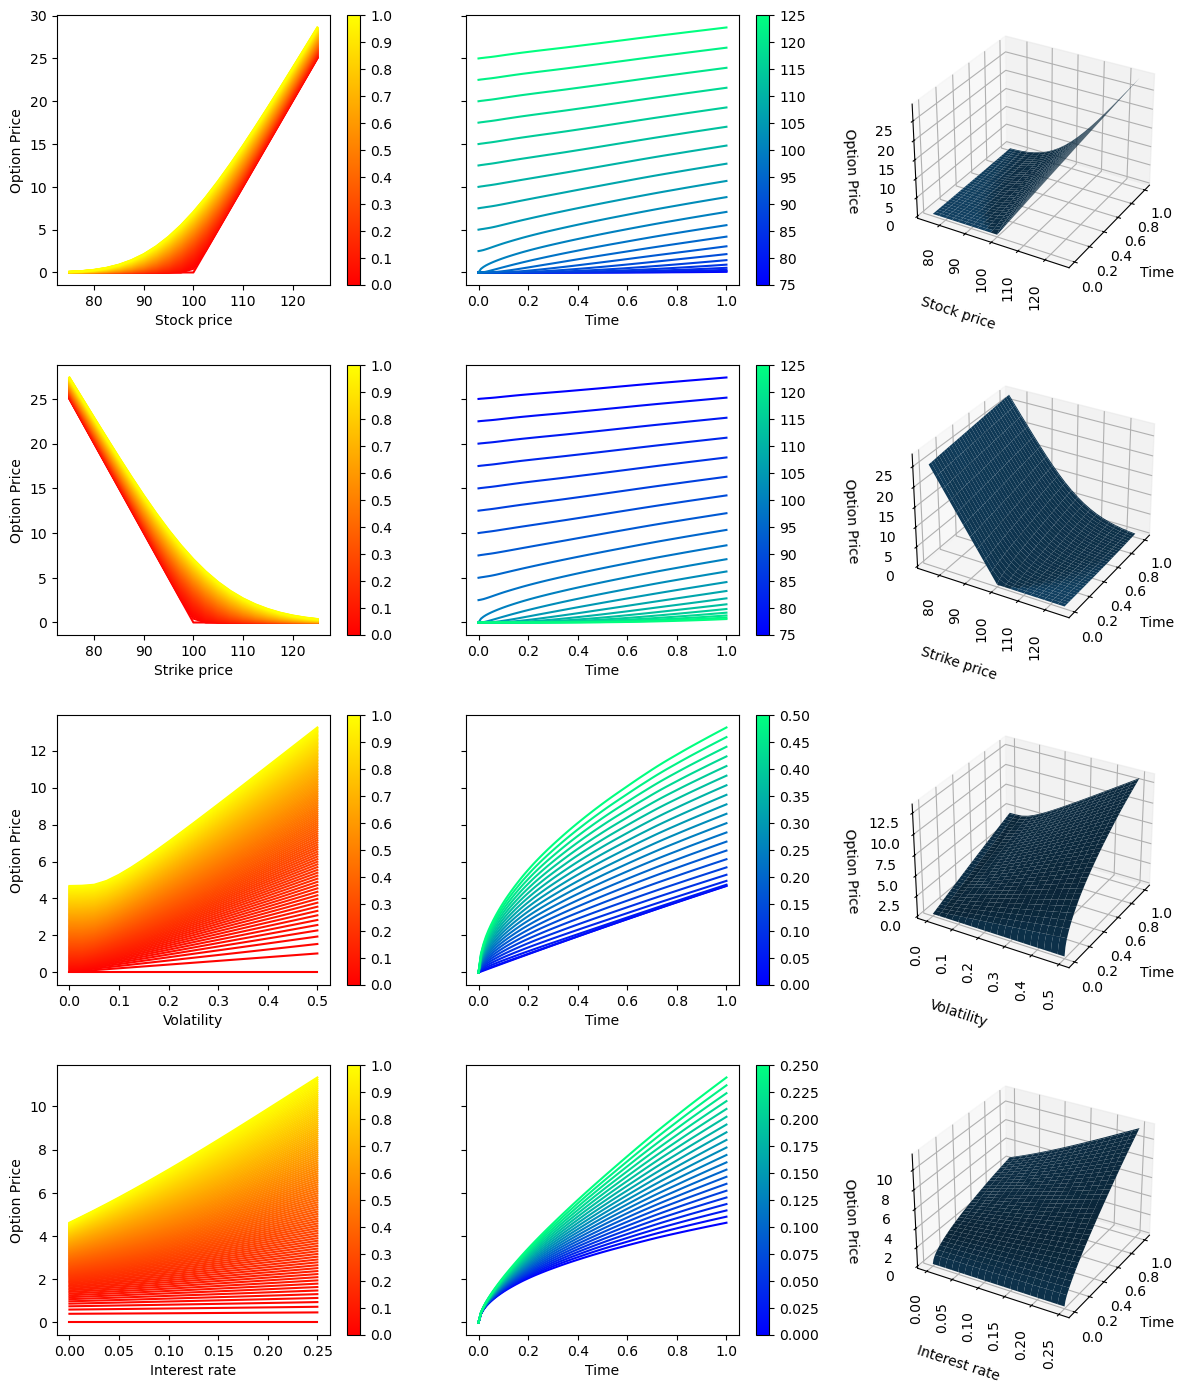

In [ ]:
# Instantiate fixed asian call option object with arithmetic averaging.
arith_fixed_asian_call = FixedAsianCallOption(S_model,
                                              strike_price=base_strike_price,
                                              averaging_method=AsianOptionAverage.ARITHMETIC)

# Generate full pane plot for time and parameter cross-sections and surfaces.
fig = OptionPlotter.plot_price_time_parameter_panel(arith_fixed_asian_call,
                                                    N_sims,
                                                    param_ranges = {"E": (75, 125),
                                                                    "S_0" : (75 ,125),
                                                                    "sigma" : (0, 0.5),
                                                                    "r" : (0, 0.25)})

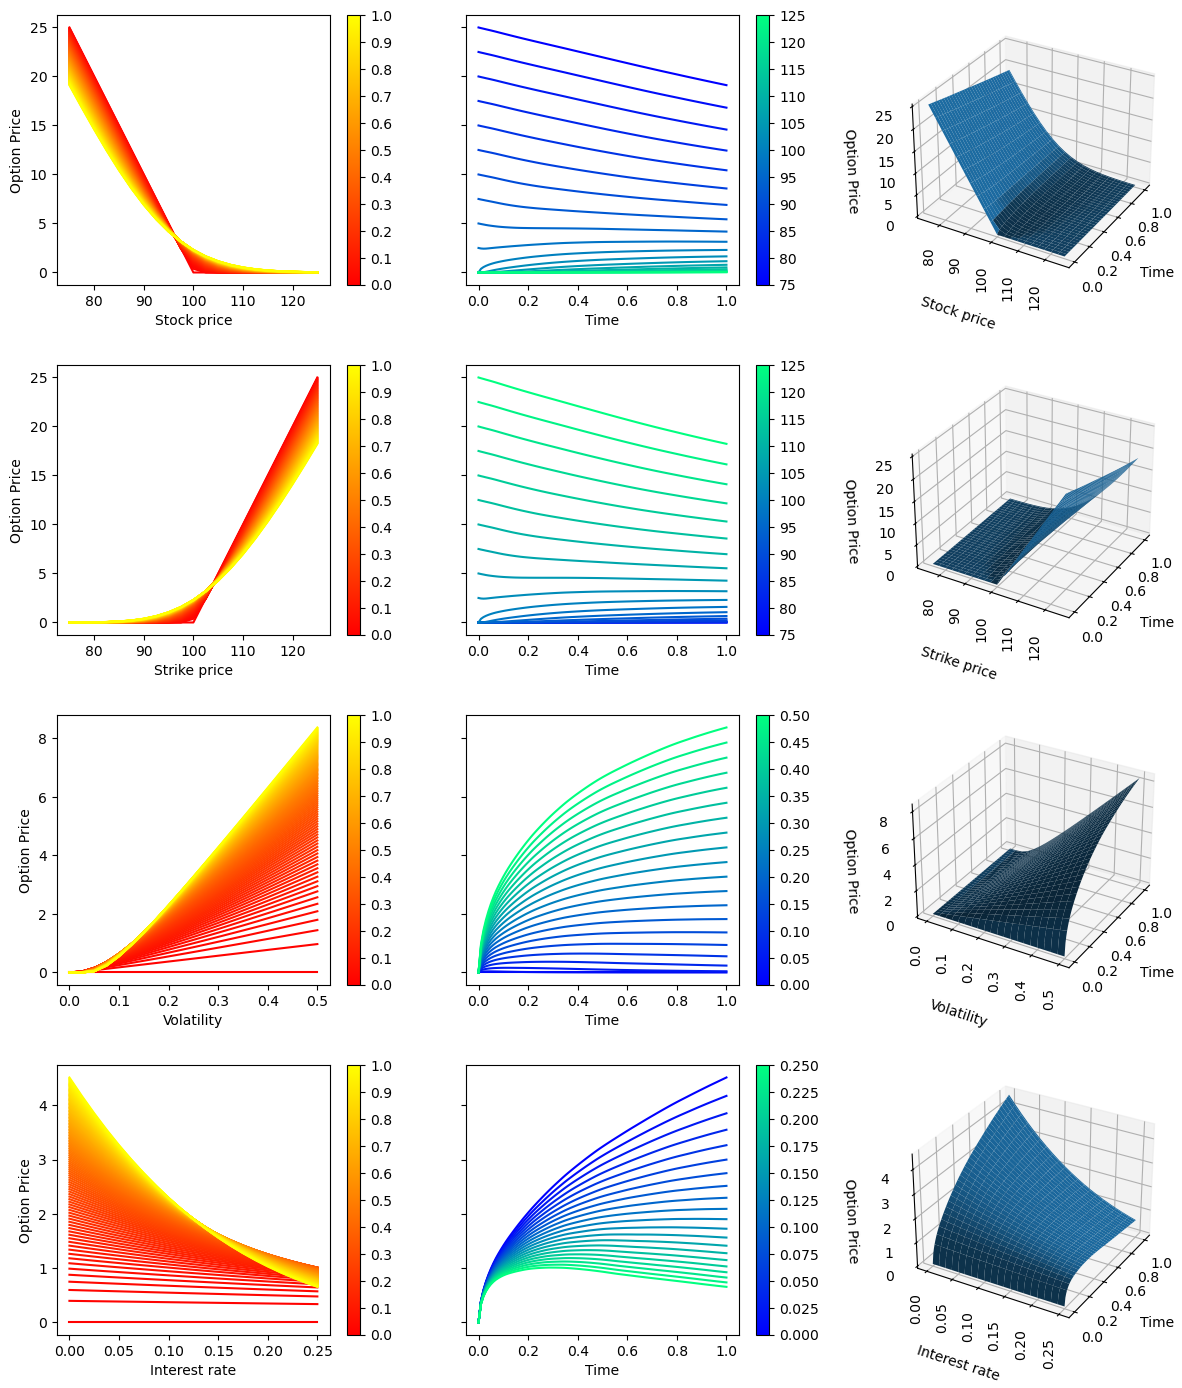

In [ ]:
# Instantiate fixed asian put option object with arithmetic averaging.
arith_fixed_asian_put = FixedAsianPutOption(S_model,
                                            strike_price=base_strike_price,
                                            averaging_method=AsianOptionAverage.ARITHMETIC)

# Generate full pane plot for time and parameter cross-sections and surfaces.
fig = OptionPlotter.plot_price_time_parameter_panel(arith_fixed_asian_put,
                                                    N_sims,
                                                    param_ranges = {"E": (75, 125),
                                                                    "S_0" : (75 ,125),
                                                                    "sigma" : (0, 0.5),
                                                                    "r" : (0, 0.25)})

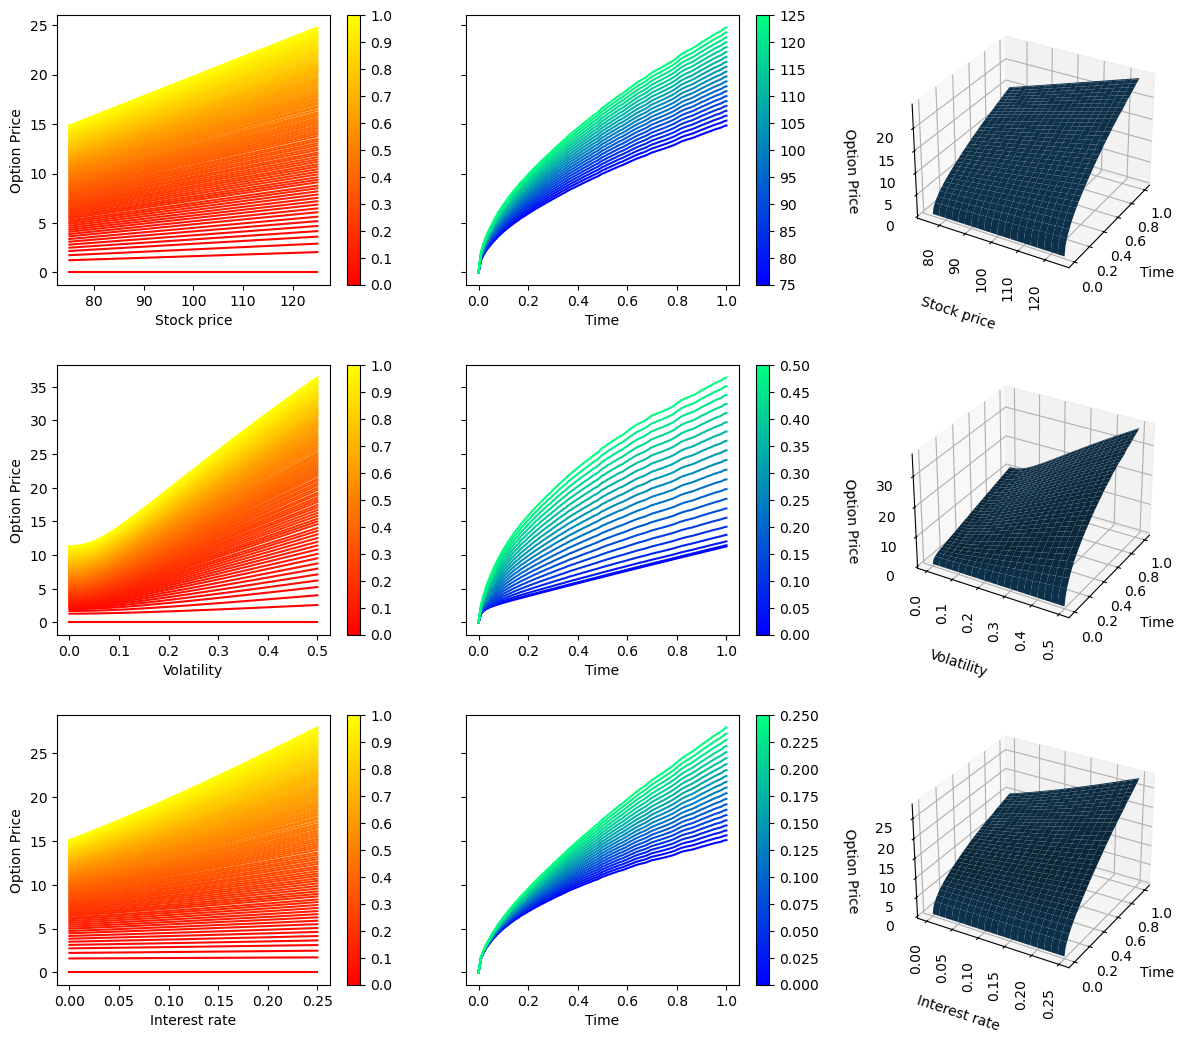

In [ ]:
# Instantiate floating lookback call option object.
float_lookback_call = FloatingLookbackCallOption(S_model, False)

# Generate full pane plot for time and parameter cross-sections and surfaces.
fig = OptionPlotter.plot_price_time_parameter_panel(float_lookback_call,
                                                    N_sims,
                                                    param_ranges = {"S_0" : (75 ,125),
                                                                    "sigma" : (0, 0.5),
                                                                    "r" : (0, 0.25)})

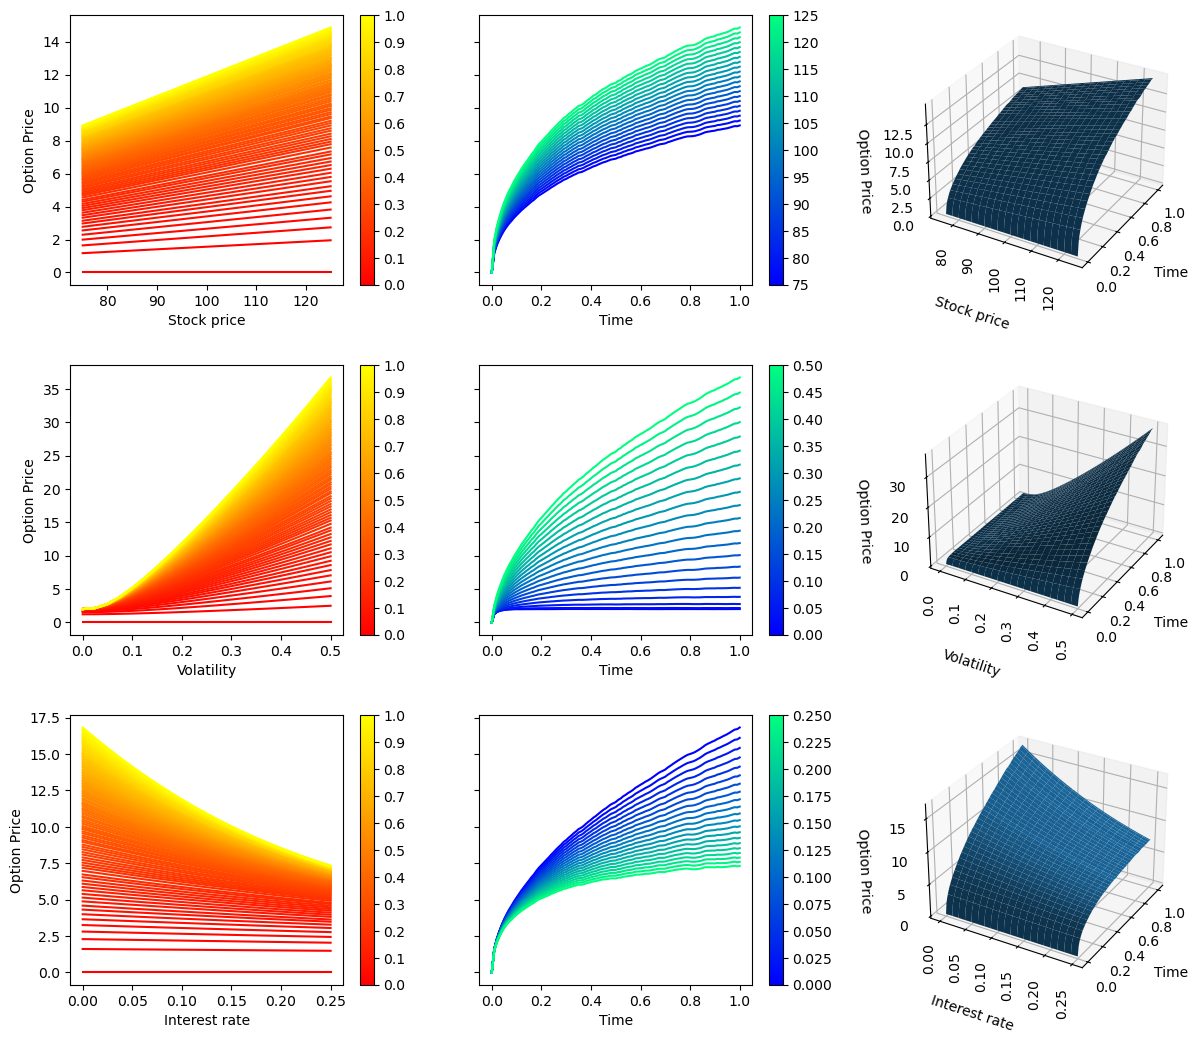

In [ ]:
# Instantiate floating lookback put option object.
float_lookback_put = FloatingLookbackPutOption(S_model)

# Generate full pane plot for time and parameter cross-sections and surfaces.
fig = OptionPlotter.plot_price_time_parameter_panel(float_lookback_put,
                                                    N_sims,
                                                    param_ranges = {"S_0" : (75 ,125),
                                                                    "sigma" : (0, 0.5),
                                                                    "r" : (0, 0.25)})

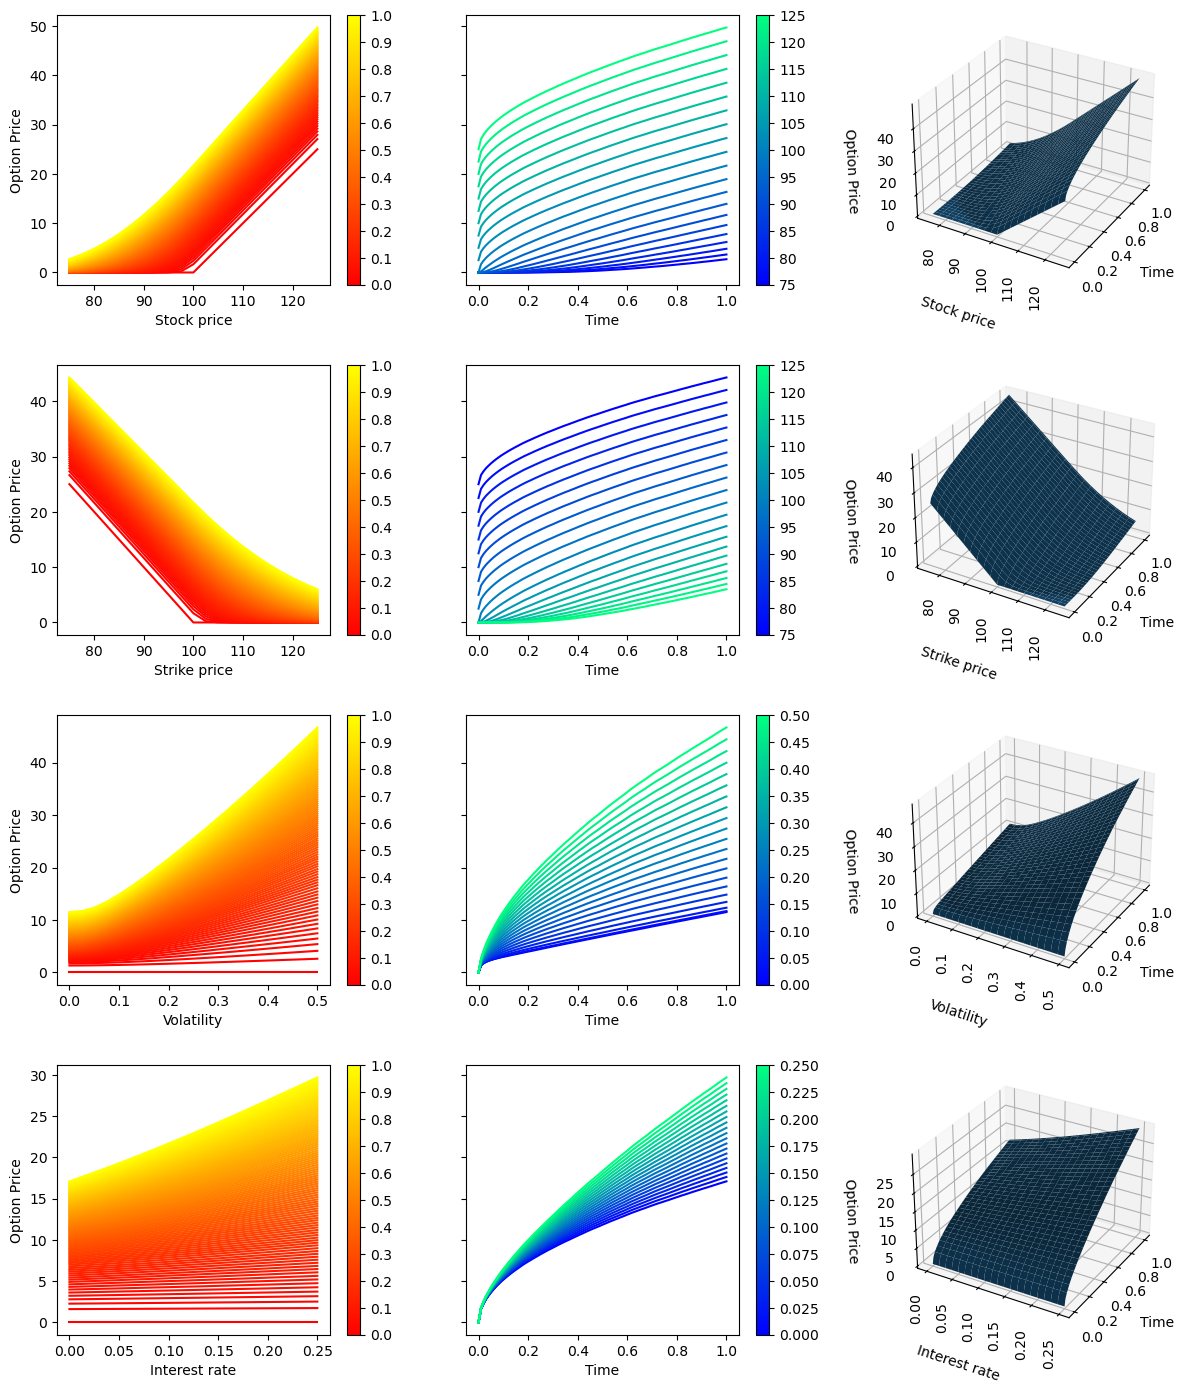

In [ ]:
# Instantiate fixed lookback call option object.
fixed_lookback_call = FixedLookbackCallOption(S_model,
                                              strike_price = base_strike_price)

# Generate full pane plot for time and parameter cross-sections and surfaces.
fig = OptionPlotter.plot_price_time_parameter_panel(fixed_lookback_call,
                                                    N_sims,
                                                    param_ranges = {"E" : (75, 125),
                                                                    "S_0" : (75 ,125),
                                                                    "sigma" : (0, 0.5),
                                                                    "r" : (0, 0.25)})

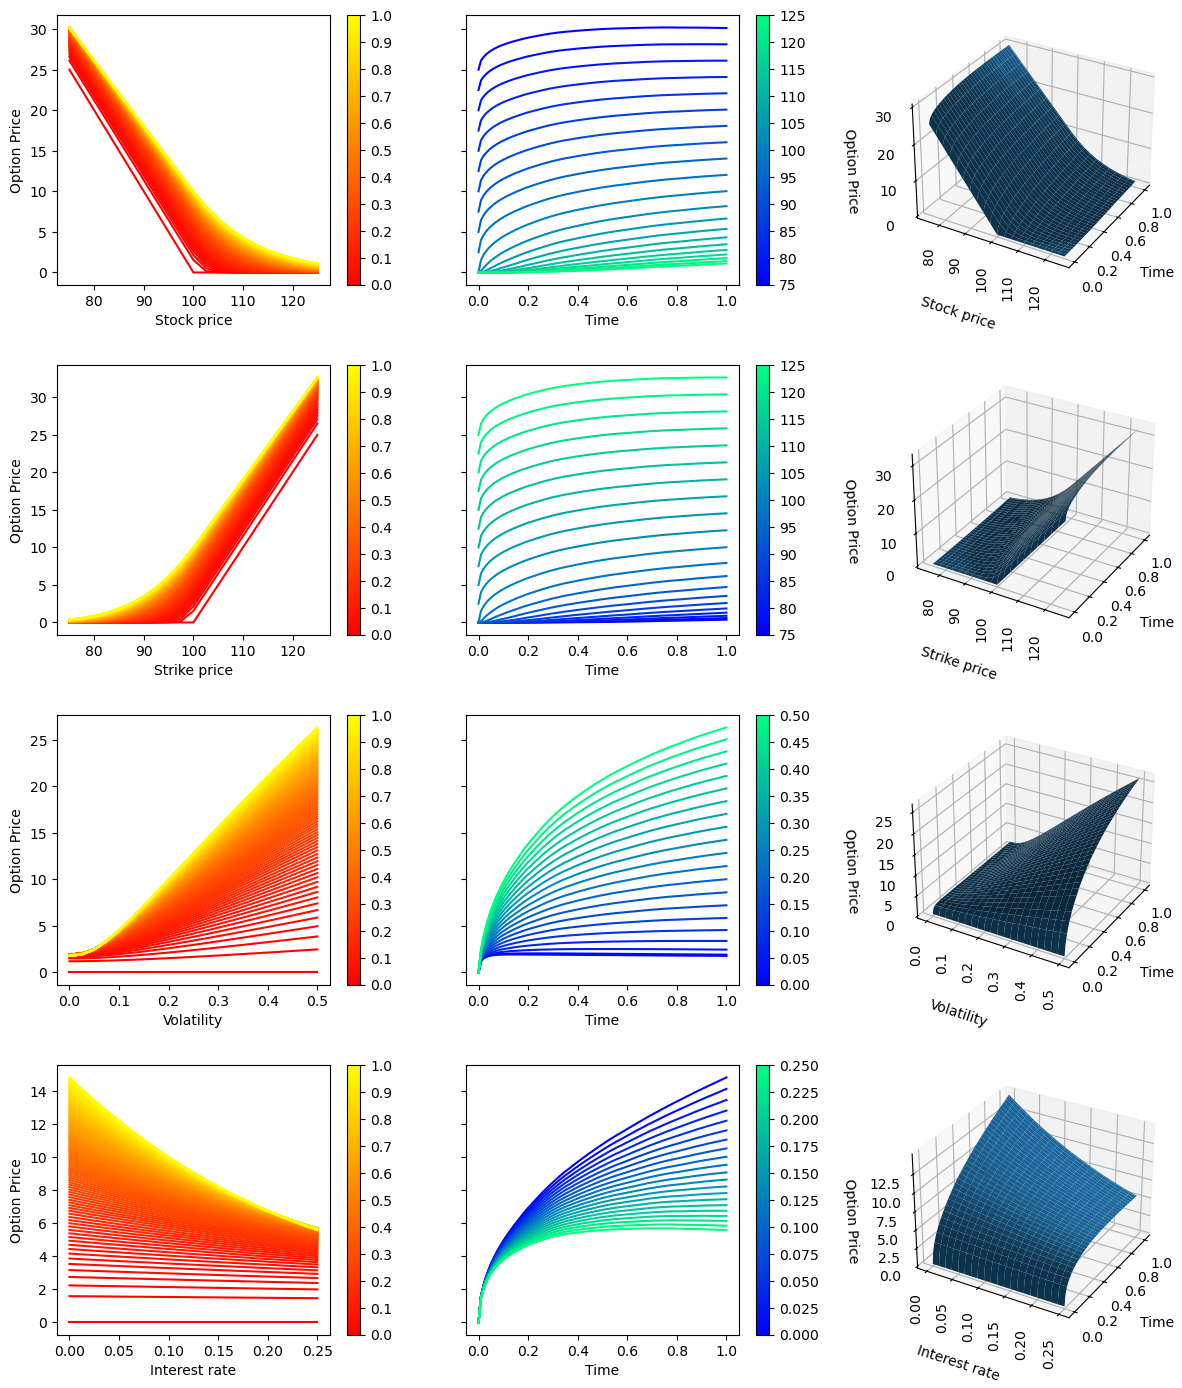

In [ ]:
# Instantiate fixed lookback put option object.
fixed_lookback_put = FixedLookbackPutOption(S_model,
                                            strike_price = base_strike_price)

# Generate full pane plot for time and parameter cross-sections and surfaces.
fig = OptionPlotter.plot_price_time_parameter_panel(fixed_lookback_put,
                                                    N_sims,
                                                    param_ranges = {"E" : (75, 125),
                                                                    "S_0" : (75 ,125),
                                                                    "sigma" : (0, 0.5),
                                                                    "r" : (0, 0.25)})

In [ ]:
# Obtain time axis from stock model object.
time_axis = S_model.time_axis

# Instantiate fixed Asian call option with geometric averaging.
geom_fixed_asian_call = FixedAsianCallOption(S_model,
                                             strike_price=base_strike_price,
                                             averaging_method = AsianOptionAverage.GEOMETRIC)

# Instantiate fixed Asian put option with geometric averaging.
geom_fixed_asian_put = FixedAsianPutOption(S_model,
                                           strike_price=base_strike_price,
                                           averaging_method = AsianOptionAverage.GEOMETRIC)

# Compute option price time series for geometric and arithmetic calls and puts.
geom_call_V = geom_fixed_asian_call.compute_price_time_series(N_sims)
arith_call_V = arith_fixed_asian_call.compute_price_time_series(N_sims)
geom_put_V = geom_fixed_asian_put.compute_price_time_series(N_sims)
arith_put_V = arith_fixed_asian_put.compute_price_time_series(N_sims)

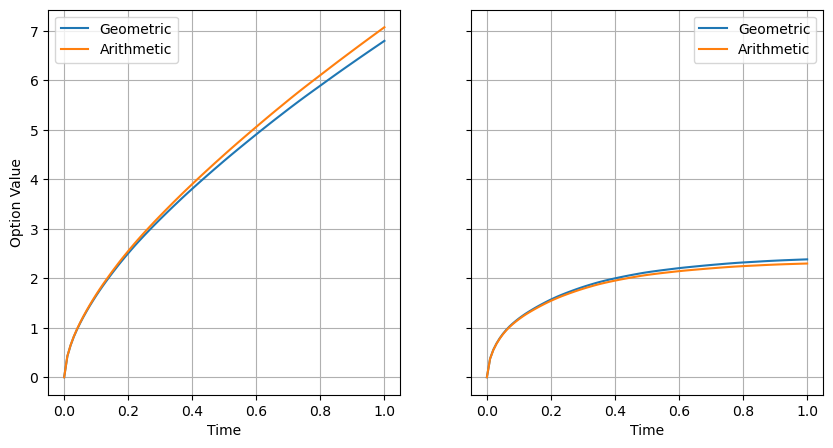

In [ ]:
# Generate call plot.
_, axs = plt.subplots(1, 2, sharey=True, figsize=(10,5))
axs[0].plot(time_axis, geom_call_V, label="Geometric")
axs[0].plot(time_axis, arith_call_V, label="Arithmetic")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Option Value")
axs[0].legend()
axs[0].grid()

# Generate put plot.
axs[1].plot(time_axis, geom_put_V, label="Geometric")
axs[1].plot(time_axis, arith_put_V, label="Arithmetic")
axs[1].set_xlabel("Time")
axs[1].legend()
axs[1].grid()

# Render plot.
plt.show()

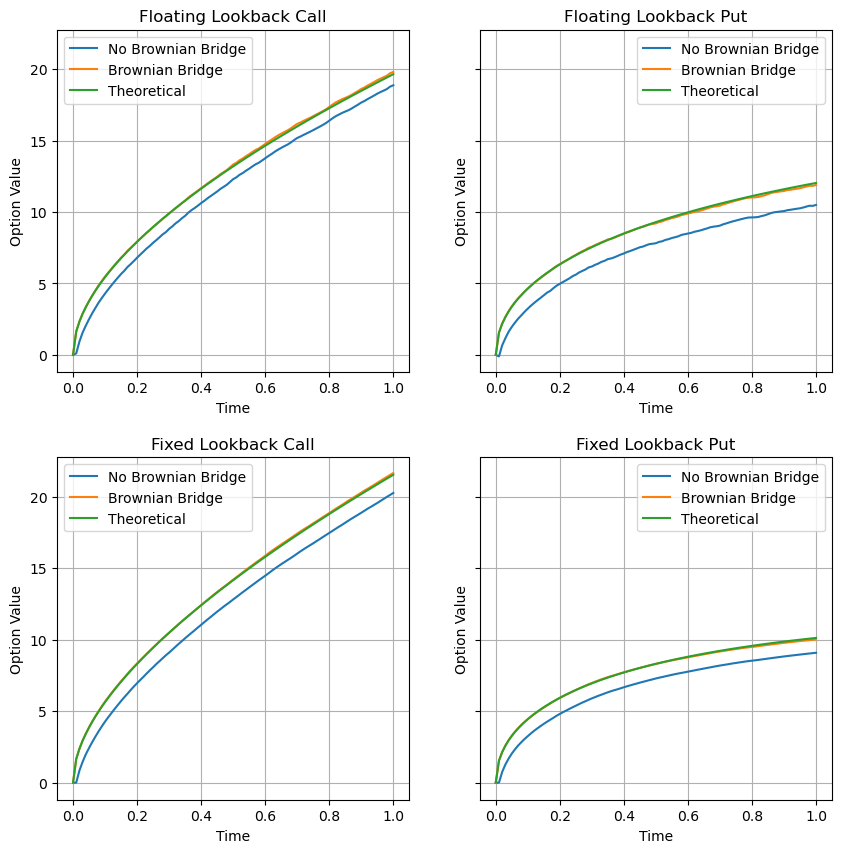

In [1936]:
import inspect

# Get time axis from stock model object
time_axis = S_model.time_axis

# Collect option object types for comparison
option_collection = {
    "Floating Lookback Call" : FloatingLookbackCallOption,
    "Floating Lookback Put" : FloatingLookbackPutOption,
    "Fixed Lookback Call" : FixedLookbackCallOption,
    "Fixed Lookback Put" : FixedLookbackPutOption
}

# Initialise plot
_, axs = plt.subplots(2, 2, sharey=True, figsize=(10,10), gridspec_kw={"hspace" : 0.25})

# Get axis list
axs_flat = axs.flatten()

# Iterate through option object types
for i, (key, val) in enumerate(option_collection.items()):

    # Get axis
    ax = axs_flat[i]

    # Get option object
    option_model = option_collection[key]

    # Get signature of option object constructor
    sig = inspect.signature(option_model.__init__).parameters.keys()

    # If constructor takes strike price, provide base strike price parameter
    if "strike_price" in sig:

        # Instantiate option object with no Brownian Bridge calculation
        no_bb_option = option_model(S_model,
                              use_brownian_bridge=False,
                              strike_price=base_strike_price)

        # Instantiate option object with Brownian Bridge calculation
        bb_option = option_model(S_model,
                                 strike_price=base_strike_price)

    else:

        # Instantiate option object with no Brownian Bridge calculation
        no_bb_option = option_model(S_model,
                                    use_brownian_bridge=False)

        # Instantiate option object with Brownian Bridge calculation
        bb_option = option_model(S_model)

    # Compute option price time series
    no_bb_V = no_bb_option.compute_price_time_series(N_sims)
    bb_V = bb_option.compute_price_time_series(N_sims)
    theoretical_V = bb_option.compute_theoretical_price_time_series()

    # Plot time series for option values

    # Not using Brownian Bridge
    ax.plot(time_axis, no_bb_V, label="No Brownian Bridge")

    # Using Brownian Bridge
    ax.plot(time_axis, bb_V, label="Brownian Bridge")

    # From theoretical formula
    ax.plot(time_axis, theoretical_V, label="Theoretical")

    # Add labels and legends
    ax.set_xlabel("Time")
    ax.set_ylabel("Option Value")
    ax.set_title(key)
    ax.legend()
    ax.grid()

# Render plot
plt.show()